## Garbage Classification using PyTorch

Humans produce tons of garbage. This garbage, as we know needs to be segregated before it is taken out of our houses, as essential as this process is for the functioning of communities and sustaining of the mother earth, it is Tedious!

We all have, at some point imagined of having a robot personal assistant who will do all the chores for us, including garbage segregation. I mean, whom are we kidding? We hate to spend minutes staring at 6 garbage bins with a soda can in our hand and wondering where it goes. The dream is not a far fetched thought, but a reality thanks to progress in deep learning.

Today we will be building one such image classification model using PyTorch.  PyTorch is a Python library with a wide variety of functions and operations, mostly used for deep learning. We will train this model by using a kaggle dataset of 2527 images belonging to 6 different garbage bins.
These being -
1. cardboard 
2. glass
3. metal
4. paper
5. plastic
6. trash. 
The dataset is obtained from kaggle. (https://www.kaggle.com/asdasdasasdas/garbage-classification) 

We will use the `opendatasets` library to download the dataset.

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

While downloading the dataset, you will be asked to provide your Kaggle username and credentails, which you can obtain using the "Create New API Token" button on your account page on Kaggle. Upload the `kaggle.json` notebook using the files tab or enter the username and key manually when prompted.

In [4]:
od.download('https://www.kaggle.com/asdasdasasdas/garbage-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adityapatkar
Your Kaggle Key: ··········


 11%|█         | 9.00M/82.0M [00:00<00:01, 54.8MB/s]

100%|██████████| 82.0M/82.0M [00:00<00:00, 236MB/s] 


Now we'll import the nessecary libraries.

In [5]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
%matplotlib inline

## Exploring the Data
 
We have downloaded the data. Now we will take a look at the images and see how the data is stored.

In [40]:
data_dir = './garbage-classification/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['glass', 'paper', 'cardboard', 'metal', 'trash', 'plastic']


As we can see, we have images classified into above 6 categories. 

# Apply Transformations

Before we can use these images for our model, we'll have to apply a few transformations. One of those is converting the images to Tensors. A tensor is a number, vector, matrix, or any n-dimensional array.


In [7]:
from torchvision.datasets import ImageFolder

transformations = transforms.Compose([transforms.Resize((64, 64 )),  transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: ./garbage-classification/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

Transforms can be chained using `transforms.Compose`. For instance, you may add `transforms.Resize` before `transforms.ToTensor()` to resize images before converting them into tensors. See the full list of transforms here: https://pytorch.org/docs/master/torchvision/transforms.html

Let's now create a function that will show us the image and its corresponding label.



In [8]:
def show_image(img, label):
    print("Label:", dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard


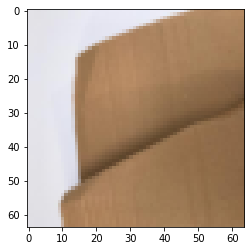

In [9]:
img, label = dataset[11]
show_image(img, label)

Label: cardboard


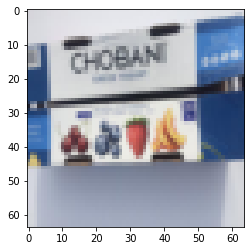

In [10]:
img, label = dataset[69]
show_image(img, label)

Label: glass


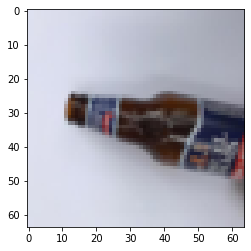

In [11]:
img, label = dataset[700]
show_image(img, label)

Now it's the time to split our dataset into train and test set. We will use the test set as our validation set so that we have more images for training.

In [12]:
random_seed = 51
torch.manual_seed(random_seed)


train_ds, test_ds = random_split(dataset, [1827, 700])
len(train_ds), len(test_ds)


(1827, 700)

## Creating Datasets & Data Loaders

Now we will create data loaders. These data loaders load the data into our model in batches.

In [13]:
batch_size = 18
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

Now we will define a helper function to visualize the batches.

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 9).permute(1, 2, 0))
        break

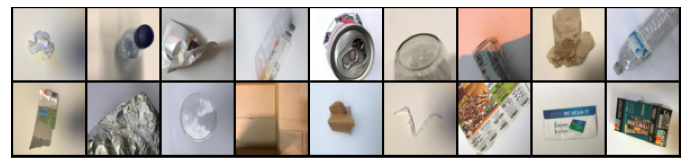

In [15]:
show_batch(train_dl)

As we can see, a batch contains randomly selected images. Let's check how many samples the dataset contains

In [16]:
len(dataset)

2527

# Using a GPU.

A GPU uses CUDA cores to accelerate our training process. Thus it is better to shift our data and model to the GPU. We will create helper functions for the same.

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available).

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) #128*32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) #256*16
        self.conv4 = conv_block(256, 512, pool=True) #512*8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1024, pool=True) #1024*4
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024,1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)

        out = self.res3(out) + out
        out = self.classifier(out)
        return out

In [22]:
model = to_device(ResNet9(3, 6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.19462250173091888, 'val_loss': 1.7900820970535278}]

In [25]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                  weight_decay, grad_clip, opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 1.5396, val_loss: 2.7678, val_acc: 0.4256
Epoch [1], last_lr: 0.00076, train_loss: 1.4812, val_loss: 1.7085, val_acc: 0.4170
Epoch [2], last_lr: 0.00100, train_loss: 1.4595, val_loss: 2.9718, val_acc: 0.4514
Epoch [3], last_lr: 0.00095, train_loss: 1.3206, val_loss: 2.5527, val_acc: 0.4126
Epoch [4], last_lr: 0.00081, train_loss: 1.0243, val_loss: 1.6403, val_acc: 0.5486
Epoch [5], last_lr: 0.00061, train_loss: 0.9016, val_loss: 0.8807, val_acc: 0.6875
Epoch [6], last_lr: 0.00039, train_loss: 0.6930, val_loss: 0.7545, val_acc: 0.7285
Epoch [7], last_lr: 0.00019, train_loss: 0.4742, val_loss: 0.6057, val_acc: 0.7742
Epoch [8], last_lr: 0.00005, train_loss: 0.3715, val_loss: 0.5759, val_acc: 0.7984
Epoch [9], last_lr: 0.00000, train_loss: 0.2655, val_loss: 0.5500, val_acc: 0.8013
CPU times: user 34.1 s, sys: 12.9 s, total: 47 s
Wall time: 1min 40s


In [27]:
epochs = 5
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [28]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                  weight_decay, grad_clip, opt_func)

Epoch [0], last_lr: 0.00008, train_loss: 0.2985, val_loss: 0.6131, val_acc: 0.7899
Epoch [1], last_lr: 0.00010, train_loss: 0.3746, val_loss: 0.7397, val_acc: 0.7528
Epoch [2], last_lr: 0.00006, train_loss: 0.3075, val_loss: 0.6249, val_acc: 0.7917
Epoch [3], last_lr: 0.00002, train_loss: 0.1820, val_loss: 0.5161, val_acc: 0.8143
Epoch [4], last_lr: 0.00000, train_loss: 0.1394, val_loss: 0.5479, val_acc: 0.8086
CPU times: user 18.3 s, sys: 7.99 s, total: 26.3 s
Wall time: 51.5 s


## Evaluating Model Performance 
 We have trained our model with 80% accuracy. This can be further increased by fine tuning the hyperparameters, changing the model architecture or using techniques like batch normalisation.

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

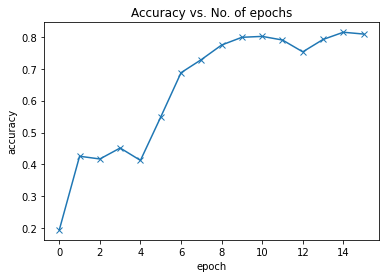

In [31]:
plot_accuracies(history)

We can also plot the training and validation losses to study the trend.

In [32]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

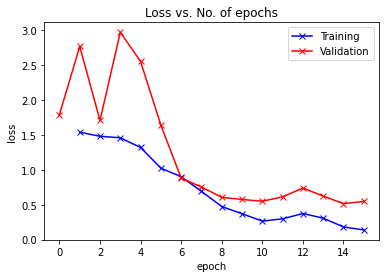

In [33]:
plot_losses(history)

It's clear from the trend that our model isn't overfitting to the training data just yet. Try removing data augmentation and residual layers one by one to study their effect on overfitting.

 let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [34]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

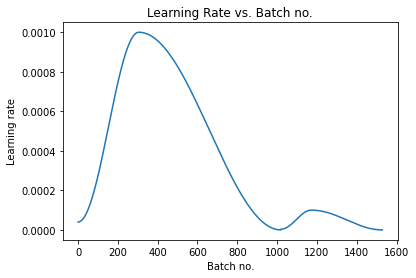

In [35]:
plot_lrs(history)

As expected, the learning rate starts at a low value, and gradually increases for 30% of the iterations to a maximum value of 0.01, and then gradually decreases to a very small value.



Let's try predicting the labels for some sample images

## Generating test predictions

We can now make predictions from the test dataset

In [42]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: paper , Predicted: paper


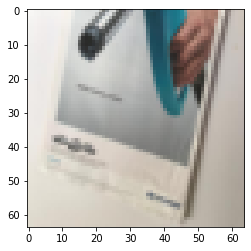

In [43]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


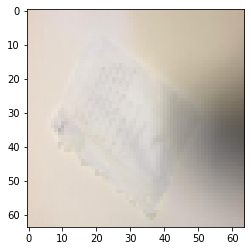

In [44]:
img, label = test_ds[699]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


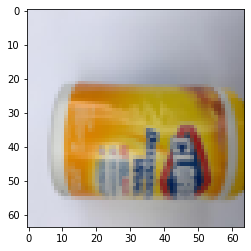

In [45]:
img, label = test_ds[420]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: paper , Predicted: paper


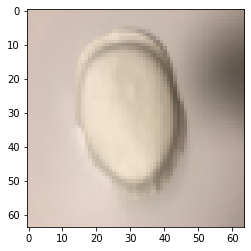

In [46]:
img, label = test_ds[121]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


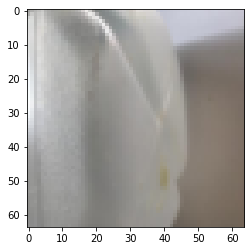

In [47]:
img, label = test_ds[312]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: cardboard , Predicted: cardboard


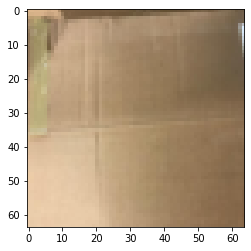

In [49]:
img, label = test_ds[495]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: metal


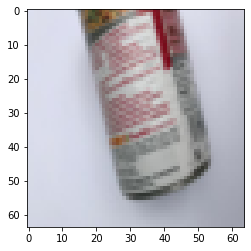

In [50]:
img, label = test_ds[221]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


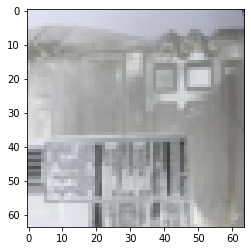

In [51]:
img, label = test_ds[111]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: metal , Predicted: trash


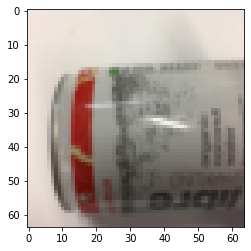

In [52]:
img, label = test_ds[12]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

As we can see, the model can sometimes give false results.

## Save to Jovian

In [53]:
!pip install jovian --upgrade --quiet

In [54]:
import jovian
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [25]:
jovian.commit(project='garbage-segregation')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/aditya-pat10/garbage-segregation


'https://jovian.ai/aditya-pat10/garbage-segregation'